# ReMi-DAS (Synthetic Demo)

This notebook demonstrates the ReMi workflow using synthetic DAS strain-rate data generated via the `noise_synthetics` package and processed with DASCore.




In [1]:
import os, sys
sys.path.append(os.path.abspath("../src"))

import numpy as np
import dascore as dc
from dascore.units import Hz
from matplotlib import pyplot as plt

from noise_synthetics.geometry import ArrayGeometry
from noise_synthetics.medium import MediumModel
from noise_synthetics.fields import TrafficField
from noise_synthetics.synthesis import SimulationConfig, synthesize_strain_rate
from noise_synthetics.io_dascore import to_dascore_patch


In [2]:
# Generate synthetic DAS strain-rate data and convert to Patch
fs = 100.0 # units: Hz
T = 600.0 # units: seconds
array = ArrayGeometry(x0=0.0, dx=1.0, n_sensors=150)

# Simple Rayleigh-wave dispersion: power-law decrease with frequency
freqs = np.linspace(2.0, 20.0, 50)
f_ref = 2.0        # Hz (reference frequency)
v_ref = 600.0      # m/s at f_ref (low-frequency phase velocity)
alpha = 0.35       # dispersion exponent (>0 => decreasing with f)
v_min = 150.0      # m/s floor to avoid unphysical low velocities
velocities = np.maximum(v_min, v_ref * (np.maximum(freqs, f_ref) / f_ref) ** (-alpha))
medium = MediumModel(freqs=freqs, velocities=velocities)

# Traffic-like Ambient Seismic Field
field = TrafficField(
    azimuth_mean_deg=0.0,
    azimuth_std_deg=360.0,
    rate_per_min=20.0,
    duration_mean_s=40.0,
    ring_min_radius_m=200.0,
    ring_max_radius_m=300.0,
)

cfg = SimulationConfig(fs=fs, T=T, fade_s=2.0)

# Synthesize and get strain-rate
_, data_disp, data_strain_rate, events = synthesize_strain_rate(
    array, medium, field, cfg, collect_events=True, enforce_bidirectional=False
)

# Convert to DASCore Patch (strain rate)
pa = to_dascore_patch(data_strain_rate, "synthetic_strain_rate", array.dx, fs)
pa = pa.set_units("1/s", distance="m", time="s").transpose("distance", "time")
pa


DASCore Patch ⚡
---------------
➤ Coordinates (distance: 150, time: 60000)
    *distance: CoordRange( min: 0.0 max: 1.49e+02 step: 1.0 shape: (150,) dtype: float64 units: m )
    *time: CoordRange( min: 2025-12-09T22:12:57.258565 max: 2025-12-09T22:22:57.248565 step: 0.01s shape: (60000,) dtype: datetime64[ns] units: s )
➤ Data (float64, units: 1.0 / s)
   [[ 0.    -0.023  0.066 ... -0.159  0.022 -0.   ]
    [-0.    -0.009  0.032 ... -0.218  0.018  0.   ]
    [-0.     0.006 -0.015 ... -0.244  0.008  0.   ]
    ...
    [-0.     0.047 -0.137 ...  0.082 -0.015  0.   ]
    [-0.     0.072 -0.188 ...  0.167 -0.032  0.   ]
    [-0.     0.05  -0.056 ...  0.134 -0.025  0.   ]]
➤ Attributes
    data_units: 1 / s
    history: ("set_units(data_units='1/s',distance='m',time='s')",)
    category: Synthetic
    id: synthetic_strain_rate

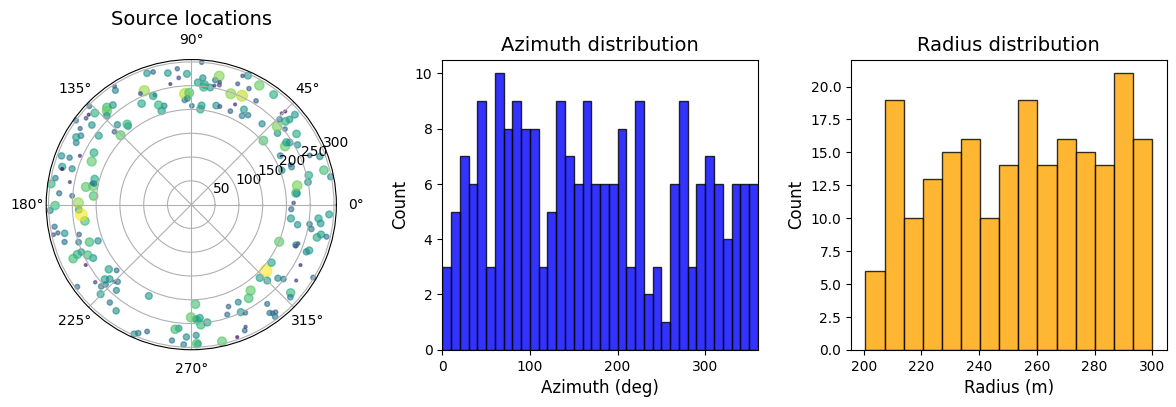

In [4]:
# Source distributions
az = np.array([ev.get('azimuth_deg', np.nan) for ev in events], dtype=float)
r = np.array([ev.get('radius_m', np.nan) for ev in events], dtype=float)
amp = np.array([ev.get('amplitude', 1.0) for ev in events], dtype=float)

amp_norm = amp / (np.median(amp) + 1e-9)
sizes = 20.0 * np.clip(amp_norm**2, 0.2, 10.0)

fig = plt.figure(figsize=(12, 4))

# Polar scatter of sources
ax0 = fig.add_subplot(1, 3, 1, projection='polar')
theta = np.deg2rad(np.mod(az, 360.0))
ax0.scatter(theta, r, s=sizes, alpha=0.6, c=amp, cmap='viridis')
ax0.set_title('Source locations', fontsize=14)

# Azimuth histogram
ax1 = fig.add_subplot(1, 3, 2)
bins_az = np.linspace(0, 360, 37)
ax1.hist(np.mod(az, 360.0), bins=bins_az, color='blue', alpha=0.8, edgecolor='k')
ax1.set_xlabel('Azimuth (deg)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Azimuth distribution', fontsize=14)
ax1.set_xlim(0, 360)

# Radius histogram
ax2 = fig.add_subplot(1, 3, 3)

r_valid = r[np.isfinite(r)]
if r_valid.size > 0:
    ax2.hist(r_valid, bins=15, color='orange', alpha=0.8, edgecolor='k')
ax2.set_xlabel('Radius (m)', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Radius distribution', fontsize=14)

fig.tight_layout()
plt.show()


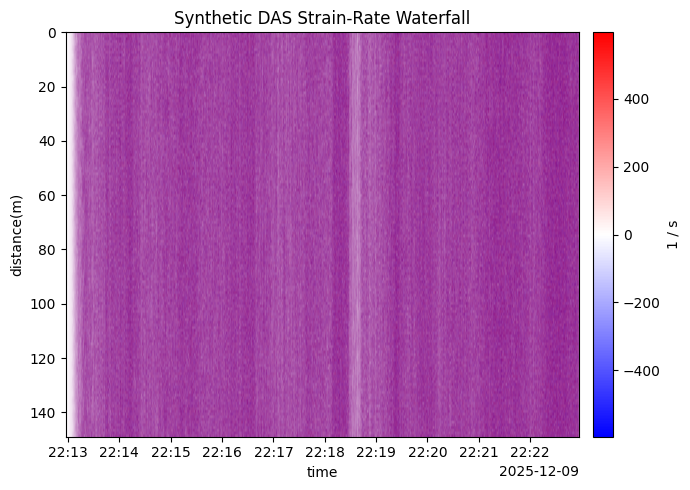

In [ ]:
# Waterfall plot
fig, ax = plt.subplots(figsize=(7, 5))
pa.viz.waterfall(ax=ax, scale=1e-1)
ax.set_title("Synthetic DAS Strain-Rate Waterfall",fontsize=14)
fig.tight_layout()
plt.show()


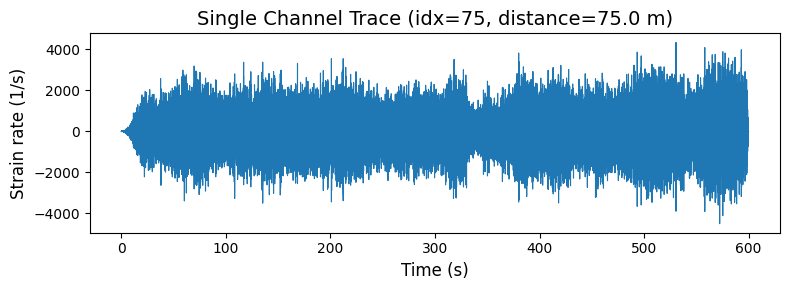

In [6]:
# Visualize a single channel recording

# Choose a channel
chan_idx = pa.shape[0] // 2
trace = pa.data[chan_idx]

_time = pa.get_coord('time')
if np.issubdtype(_time.dtype, np.datetime64):
    t = (_time - _time[0]) / np.timedelta64(1, 's')
else:
    t = np.asarray(_time)

dist = pa.get_coord('distance')[chan_idx]

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(t, trace, lw=0.8)
ax.set_title(f"Single Channel Trace (idx={chan_idx}, distance={dist:.1f} m)", fontsize=14)
ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Strain rate (1/s)", fontsize=12)
fig.tight_layout()
plt.show()


In [7]:
# ReMi processing pipeline using DASCore

def taper_time(patch, time, window_type):
    return patch.taper(time=time, window_type=window_type)

def taper_distance(patch, distance, window_type):
    return patch.taper(distance=distance, window_type=window_type)

def taup(patch, velocities):
    return patch.tau_p(velocities)

def dft_time(patch):
    return patch.dft(dim="time", real=True)

# Chunk -> Taper (time) -> Taper (distance) -> Tau-p -> DFT
sp = dc.spool(pa)
sp_chunk = sp.chunk(time=30, overlap=10)
sp_taper_t = dc.spool(sp_chunk.map(taper_time, time=0.1, window_type="hann"))
sp_taper_td = dc.spool(sp_taper_t.map(taper_distance, distance=0.1, window_type="hann"))
sp_taup = dc.spool(sp_taper_td.map(taup, velocities=np.arange(v_min-50, v_ref+200, 5)))
sp_dft = dc.spool(sp_taup.map(dft_time))

sp_dft


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

DASCore MemorySpool 🧵 (29 Patches)
    Time Span: <560.0s> 2025-12-09T22:12:57.258565 to 2025-12-09T22:22:17.258565

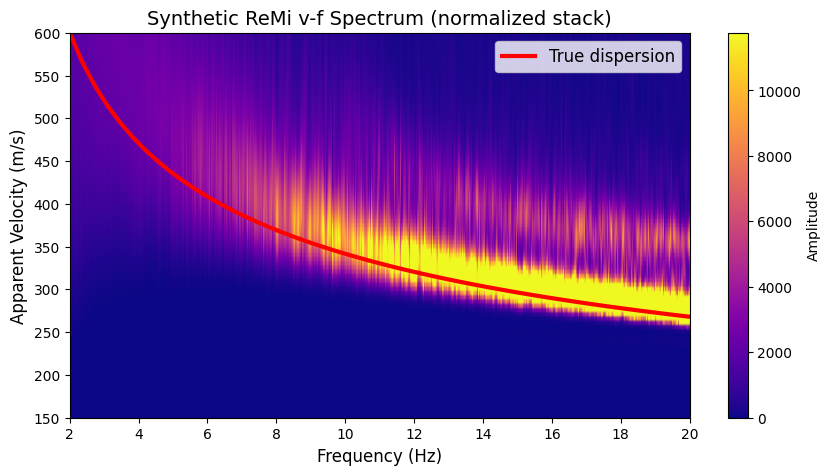

In [ ]:
# Normalized p–f stack computation and visualization

n_freq = sp_dft[0].data.shape[0]
half = n_freq // 2

if n_freq % 2 == 0:
    summed_avg_stack = np.zeros((half, sp_dft[0].data.shape[1]))
else:
    summed_avg_stack = np.zeros((half + 1, sp_dft[0].data.shape[1]))

for patch in sp_dft:
    power_spectrum = (patch.data * np.conj(patch.data)).real

    if n_freq % 2 == 0:
        neg = power_spectrum[:half, :]
        pos = power_spectrum[half:, :]
        neg_flipped = np.flipud(neg)
        summed = pos + neg_flipped
    else:
        pos = power_spectrum[: half + 1]
        neg = power_spectrum[half + 1 :]
        neg_flipped = np.flipud(neg)
        summed = pos + neg_flipped[: pos.shape[0]]

    avg = np.sum(summed, axis=0) / len(summed)
    summed_avg = summed / np.maximum(avg, 1e-12)
    summed_avg_stack = summed_avg_stack + summed_avg

freq = sp_dft[0].get_coord("ft_time")[: summed.shape[1]]
slowness = sp_dft[0].get_coord("slowness")[half:]

from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
extent = [freq[0], freq[-1], 1 / slowness[0], 1 / slowness[-1]]
im = ax.imshow(
    summed_avg_stack**2,
    aspect="auto",
    origin="lower",
    extent=extent,
    cmap="plasma",
    vmin=0,
    vmax=np.max(summed_avg_stack**2) * 0.05, # adjust vmax for optimal visibility
)

ax.plot(freqs, velocities, "r", linewidth=3, label="True dispersion")
ax.set_xlabel("Frequency (Hz)", fontsize=12)
ax.set_ylabel("Apparent Velocity (m/s)", fontsize=12)
ax.set_title("Synthetic ReMi p-f Spectrum (normalized stack)", fontsize=14)
fig.colorbar(im, ax=ax, label="Amplitude")
ax.legend(loc="upper right", fontsize=12)
ax.set_xlim(2, 20)
ax.set_ylim(v_min, v_ref)
plt.show()
